In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [3]:
# model hyperparameters 

dataset_path = '~/datasets'

cuda = True
Device = torch.device("cuda" if cuda else "cpu")
# print(Device)

batch_size = 128
img_size = (32,  32)  # (width, height)

input_dim = 3
hidden_dim = 512
latent_dim = 16
n_embeddings = 512
output_dim = 3 
commitment_beta = 0.25 

lr = 2e-4 
epochs = 50 
print_step = 50 

## Step 1. Load (or downlaod) Dataset

In [4]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

kwargs = {
    'num_workers': 1,
    'pin_memory': True
}

train_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = CIFAR10(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, **kwargs)



Files already downloaded and verified
Files already downloaded and verified


## Step 2. Define out model: Vector Quantized Variational AutoEncoder (VQ-VAE)

In [10]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4, 4, 3, 1), stride=2):
        super(Encoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4, padding=0)
        
        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)
        
    def forward(self, x):
        
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(y)
        y = self.residual_conv_2(x)
        y = y+x
        
        y = self.proj(y)
        return y
    

class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity
    


class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.in_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):

        x = self.in_proj(x)
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y





class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

In [11]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(Device)

## Step 3. Define Loss function and optimizer

In [12]:
from torch.optim import Adam 

mse_loss = nn.MSELoss()

optimizer = Adam(model.parameters(), lr=lr)

## Step 4. Train Vector Quantized Variational AutoEncoder

In [13]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0 
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(Device)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss =  mse_loss(x_hat, x)

        loss = recon_loss + commitment_loss * commitment_beta + codebook_loss

        loss.backward()
        optimizer.step()

        if batch_idx % print_step == 0:
            print("epoch:", epoch + 1,
                   "(", batch_idx + 1,
                    ") recon_loss:", recon_loss.item(),
                    " perplexity: ", perplexity.item(),
                    " commit_loss: ", commitment_loss.item(), 
                    "\n\t codebook loss: ", codebook_loss.item(),
                    " total_loss: ", loss.item(), "\n" 
                         )


print("Finish!!")


Start training VQ-VAE...
epoch: 1 ( 1 ) recon_loss: 0.40043267607688904  perplexity:  50.24223327636719  commit_loss:  0.0018107109935954213 
	 codebook loss:  0.007242843974381685  total_loss:  0.40812820196151733 

epoch: 1 ( 51 ) recon_loss: 0.030452219769358635  perplexity:  58.695465087890625  commit_loss:  0.03801145404577255 
	 codebook loss:  0.1520458161830902  total_loss:  0.19200089573860168 

epoch: 1 ( 101 ) recon_loss: 0.017298279330134392  perplexity:  168.6407928466797  commit_loss:  0.029033992439508438 
	 codebook loss:  0.11613596975803375  total_loss:  0.14069274067878723 

epoch: 1 ( 151 ) recon_loss: 0.014135440811514854  perplexity:  219.08016967773438  commit_loss:  0.025434937328100204 
	 codebook loss:  0.10173974931240082  total_loss:  0.12223392724990845 

epoch: 1 ( 201 ) recon_loss: 0.012728840112686157  perplexity:  277.5077209472656  commit_loss:  0.02577986940741539 
	 codebook loss:  0.10311947762966156  total_loss:  0.12229328602552414 

epoch: 1 ( 25

## Step 5. Evaluation the model

In [14]:
import matplotlib.pyplot as plt

def draw_sample_image(x, postfix):

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

In [ ]:
model.eval()

with torch.no_grad():
    
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(Device)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)

        print("perplexity: ", perplexity.item(),
              "commit_loss: ", commitment_loss.item(),
              "codebook loss: ", codebook_loss.item())
        
        break

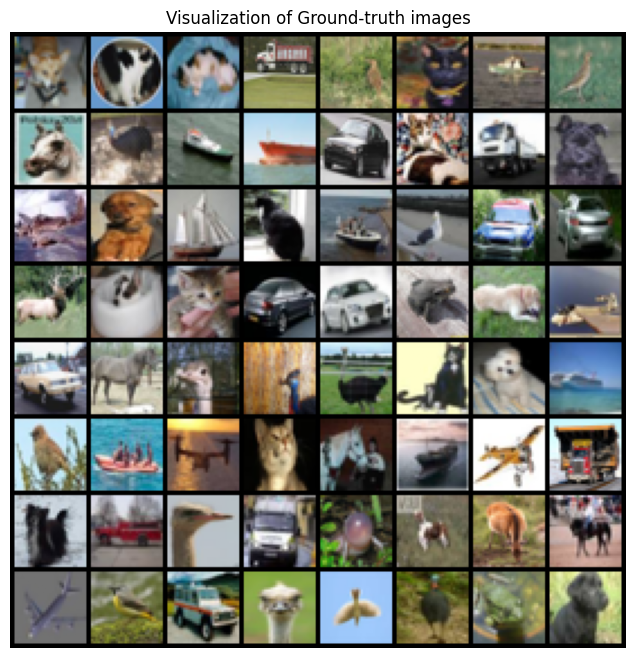

In [15]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")

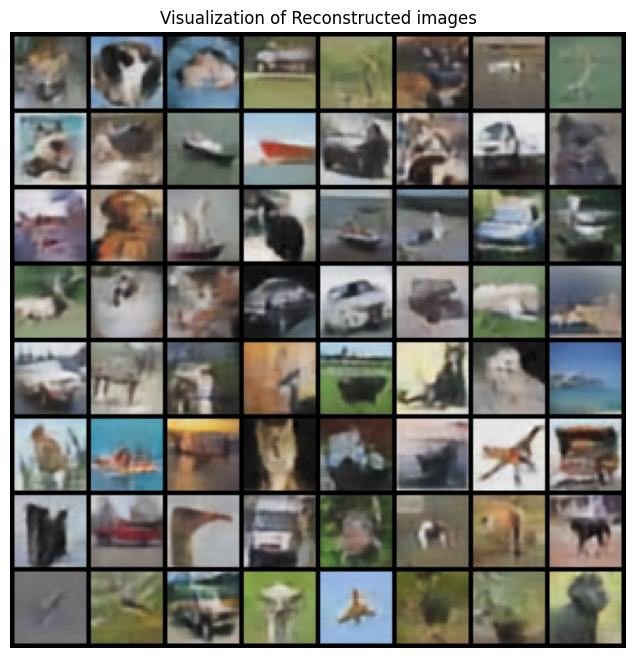

In [16]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")

## Step 6. Generate samples via random codes

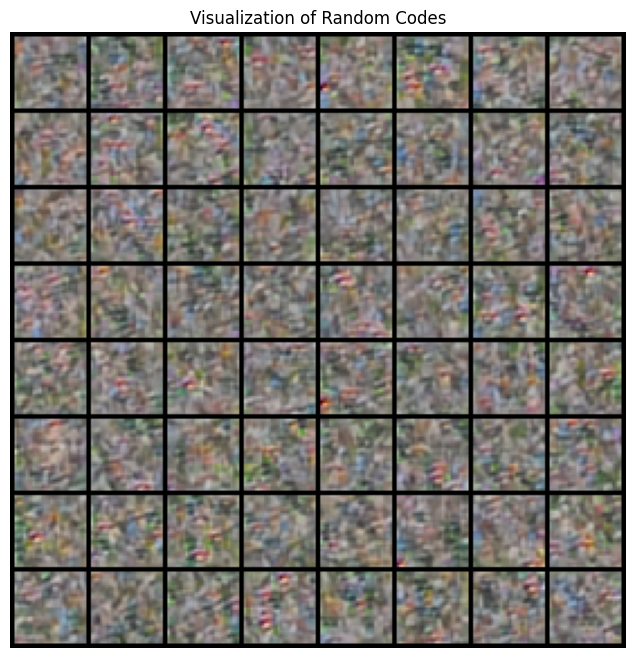

In [17]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(Device)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(Device))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))



draw_random_sample_image(codebook, decoder, indices_shape=(batch_size // 2, 8, 8))